In [1]:
import pyprojroot
import sys
import pandas as pd
package_path = pyprojroot.here().__str__()
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
from utils import LoadData, AbsPaths

In [10]:
final_data='operational_rdbms.csv'
df = LoadData().from_csv(file_name=final_data)
df.loc[:,'tourney_name']=df.tourney_name.str.upper() ###AGREGAR A CALIDAD DE DATOS.

'/Users/scordobay/Documents/ProductoDatos/predict-roland-garros-positions/reports/figures/'

In [13]:
def config_inputs(data, nominal_variables=None, ordinal_variables=None):
    if nominal_variables==None:
        nominal_variables=['surface', 'tourney_name']#,'id']
    if ordinal_variables==None:
        ordinal_variables=['round','tourney_date','id']
    for i in nominal_variables:
        data=one_hot_codification(data, i)
    for i in ordinal_variables:
        data=ordinal_codification(data,i)
    return data

In [14]:
def one_hot_codification(data:pd.DataFrame, variable:str):
    
    
    new_variables= pd.get_dummies(data[variable], drop_first=True)
    data.loc[:,new_variables.columns]=new_variables
    data=data.drop(columns=variable)
    #data=pd.concat([data.drop(columns=variable),new_variables],axis=1)
    return data

In [15]:
def ordinal_codification(data:pd.DataFrame, variable:str):
    import numpy as np

    for i,j in enumerate(np.sort(df[variable].unique())):
        data.loc[data[variable]==j,variable+'_Cod']=i
    
    data=data.drop(columns=variable)
    return data

In [16]:
df2=config_inputs(df)

/var/folders/pj/k39rkm7n70zfpx2h1pd48nyh0000gn/T/ipykernel_97727/1066694630.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_variables.columns]=new_variables
/var/folders/pj/k39rkm7n70zfpx2h1pd48nyh0000gn/T/ipykernel_97727/1066694630.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,new_variables.columns]=new_variables


In [17]:
def make_train_test_split(x, y):

    from sklearn.model_selection import train_test_split

    (x_train, x_test, y_train, y_test) = train_test_split(
        x,
        y,
        test_size=0.25,
        random_state=42,
    )
    return x_train, x_test, y_train, y_test

In [18]:
def eval_metrics(y_true, y_pred):

    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
#precision={}
# exhaustividad

    return mse, mae, r2

In [6]:
def report(estimator, mse, mae, r2):

    print(estimator, ":", sep="")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R2: {r2}")

In [20]:
def save_best_estimator(estimator):

    import os
    import pickle

    if not os.path.exists("models"):
        os.makedirs("models")
    with open("models/estimator.pickle", "wb") as file:
        pickle.dump(estimator, file)

In [21]:
def load_best_estimator():

    import os
    import pickle

    if not os.path.exists("models"):
        return None
    with open("models/estimator.pickle", "rb") as file:
        estimator = pickle.load(file)

    return estimator

In [22]:
def train_estimator(param_grid, x, y, path_img=None,class_names=None, n_splits=5, verbose=1):

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    
    #x, y = load_data()
    x_train, x_test, y_train, y_test = make_train_test_split(x, y)

    # -------------------------------------------------------------------------
    # Búsqueda de parámetros con validación cruzada
    #
    estimator = GridSearchCV(
        estimator=RandomForestClassifier(
            random_state=42,
        ),
        param_grid=
        param_grid,
        cv=n_splits,
        refit=True,
        verbose=0,
        return_train_score=False,
    )
    # -------------------------------------------------------------------------

    estimator.fit(x_train, y_train)

    estimator = estimator.best_estimator_

    mse, mae, r2 = eval_metrics(y_test, y_pred=estimator.predict(x_test))
    if verbose > 0:
        report(estimator, mse, mae, r2)
    
    if class_names!=None:
        disp = ConfusionMatrixDisplay.from_estimator(
        estimator,
        x_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=None,
        )
        print(disp.confusion_matrix)
        if path_img==None:
            path_img=AbsPaths().get_abs_path_folder(folder_name='figures')
            
        plt.savefig(path_img+'ConfusionMatrix.png')
        plt.show()
    
    best_estimator = load_best_estimator()
    if best_estimator is None or estimator.score(x_test, y_test) > best_estimator.score(
        x_test, y_test
    ):
        best_estimator = estimator

    save_best_estimator(best_estimator)

In [23]:
import numpy as np

param_grid = { 
    'n_estimators': [100, 200, 250, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': np.arange(2,16,2),
    'max_depth' : np.arange(4,28,4),
    'criterion' :['gini', 'entropy','log_loss'],
    'class_weight':['balanced', 'balanced_subsample']
}

x=df2.drop(columns='round_Cod').values
y=df2.round_Cod.values
class_names=list(map(lambda x: 'R-'+str(x) , list(sorted(set(df['round'])))))

In [ ]:
train_estimator(
    param_grid=param_grid,
    x=x,
    y=y,
    class_names=class_names,
    n_splits=5,
    verbose=1
)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=24, n_estimators=200, random_state=42):
  MSE: 1.6567028985507246
  MAE: 0.7853260869565217
  R2: 0.09038260208338222
[[ 13   2   6   6   3   1   5]
 [  6   1   6   7   5   4   8]
 [  5   5   2  20  14  11  17]
 [  3   2   6  16  20  15  55]
 [  2   2   6  22  36  34 156]
 [  3   0   3   9  32  43 454]
 [  0   3   4  16  34  91 994]]


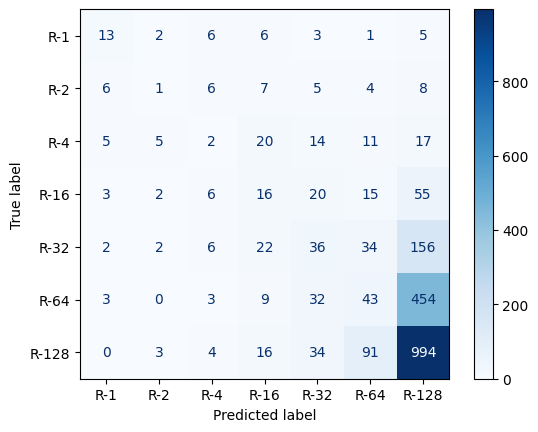

In [259]:
train_estimator(
    param_grid=param_grid,
    x=x,
    y=y,
    class_names=class_names,
    n_splits=5,
    verbose=1
)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       min_samples_split=8, n_estimators=200, random_state=42):
  MSE: 1.5742753623188406
  MAE: 0.802536231884058
  R2: 0.13563967327551574
[[ 15   7   5   6   1   1   1]
 [ 10   3   6   9   6   2   1]
 [  5   5  11  25  14   5   9]
 [  7   4  11  16  35  14  30]
 [  2   4  18  43  64  36  91]
 [  3   3   6  28  72  81 351]
 [  1   4  10  30 100 148 849]]


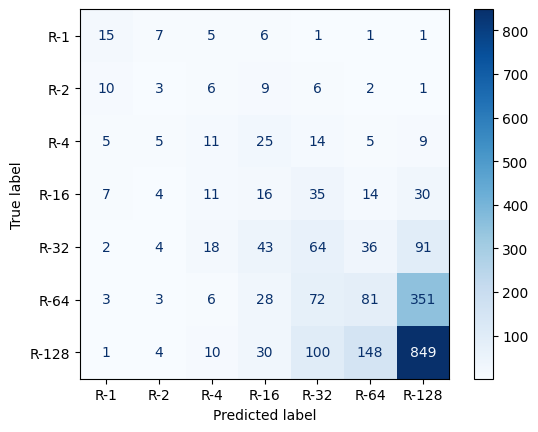

In [257]:
train_estimator(
    param_grid=param_grid,
    x=x,
    y=y,
    class_names=class_names,
    n_splits=5,
    verbose=1
)